## **Diffusion Model** 
- Diffusion models are generative latent variable models that transforms noise into data by learning denoising.

- These models are used for various tasks, including image generation and data synthesis.

- Diffusion models often produce high-quality, sharp images with fine details compared to VAE and GANs.

- Diffusion models are more stable compared to GANs during training.

- Paper:
 
    - [Deep Unsupervised Learning using Nonequilibrium Thermodynamics](https://arxiv.org/abs/1503.03585) - Diffusion Models Introduced(2015)
    - [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) - Diffusion Models Becomes Popular (2020)

### **Key Concepts**
1. Forward Diffusion Process: 
    - In forward diffusion process, we gradually add noise to original data over a series of steps, transforming it into pure noise(Gaussian).

    - It is a predetermined Markov chain based on a noise schedule. 

2. Reverse Diffusion Process:
    - In reverse diffusion process, we attempt to reconstruct the original data from the noisy version by progressively removing the noise.
    
    - Training a neural network takes place in this process.

3. Noise Schedule:
    - The noise schedule is a crucial component that defines how noise is added to the data throughout the forward diffusion process and, inversely, how it is removed during the reverse process. 
    
    - The noise schedule controls the progression of noise levels at each diffusion step, impacting the model's performance in generating high-quality samples.

    - Example: Linear Schedule, Cosine Schedule

    - $β$ represents the variance of the noise added to the data at each diffusion step. It controls how much noise is injected into the data as the diffusion process progresses.

    - $𝛼$ represents the fraction of the data that remains unchanged (i.e., the proportion of the original data's signal that is retained) after adding noise. It is defined as: $α  = 1− β$ at every diffusion steps.
​


### **Forward Diffusion Process**

<center>
    <img src="./assets/forward_process.png" width="600"/>
</center>

- Forward Diffusion Process Mathematical Representation
<center>
    <img src="./assets/fd_formula.png" width="600"/>
</center>

- The above process for higher number of steps will be computationally expensive. So above equations can be reparameterized into following equation where new images at any step could be generated from the original image rather than using strictly image at previous step.

- After reparameterization:

<center>
    <img src="./assets/fd_formula_reparameterized.png" width="600"/>
</center>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

We will be using MNIST Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=16, shuffle=True)


Let's visualize forward diffusion process

In [3]:
# Select a sample image for visualization
sample_image, _ = mnist_dataset[0]
sample_image = sample_image.numpy().squeeze()

In [4]:
def linear_beta_schedule(T, beta_start=0.0001, beta_end=0.02):
    """
    Create a linear schedule for beta_t values.
    
    Args:
        T (int): Total number of diffusion steps.
        beta_start (float): Starting value of noise level beta.
        beta_end (float): Ending value of noise level beta.
        
    Returns:
        np.ndarray: The beta schedule for the diffusion process.
    """
    betas = np.linspace(beta_start, beta_end, T)
    
    return betas

In [5]:
def forward_diffusion_process(x, num_steps=10, beta_start=0.0001, beta_end=0.02):
    # Create a linear noise schedule for beta values
    beta_schedule = linear_beta_schedule(num_steps, beta_start, beta_end)
    
    alpha_schedule = 1 - beta_schedule
    
    alpha_cumprod = np.cumprod(alpha_schedule)  # This is used to calculate the amount of retained signal across multiple steps.

    # Initialize a list to store the noisy images
    noisy_images = [x]  # Add the original image to the list

    # Iteratively add noise
    for t in range(1, num_steps):
        noise = np.random.normal(0, 1, x.shape)
        x_noisy = np.sqrt(alpha_cumprod[t]) * x + np.sqrt(1 - alpha_cumprod[t]) * noise
        noisy_images.append(x_noisy)

    return noisy_images

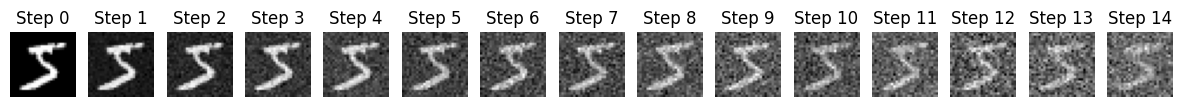

In [6]:
# Apply the forward process to the sample image
num_steps = 15
noisy_images = forward_diffusion_process(sample_image, num_steps)

# Visualize the results
fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(noisy_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Step {i}')
plt.show()

### **Reverse Diffusion Process**
<center>
    <img src="./assets/reverse_process.png" width=600/>
</center>

- The reverse process aims to gradually remove noise from a noisy sample (typically Gaussian noise) to reconstruct the original data distribution.

- A neural network is trained to predict the noise present in the noisy sample at each step.

- The objective of neural network is to minimize the error in noise prediction i.e. to reduce MSE loss.

- Denoising formula:

<center>
    <img src="./assets/denoising.png" width=600/>
</center>


In [7]:
# Define a simple neural network for noise prediction
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28)
        )
        
    def forward(self, x):
        return self.model(x)

In [8]:
# Function to train the noise predictor
def train_noise_predictor(model, dataloader, num_steps=10, beta_start=0.0001, beta_end=0.02, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create a schedule for beta values
    beta_schedule = linear_beta_schedule(num_steps, beta_start, beta_end)

    alpha_schedule = 1 - beta_schedule
    
    alpha_cumprod = np.cumprod(alpha_schedule)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        for batch_idx, (data, _) in enumerate(dataloader):
            # Flatten the images
            data = data.view(-1, 28*28).to(device)
            
            optimizer.zero_grad()

            # Forward process: add noise
            t = np.random.randint(0, num_steps)
            alpha_bar_t = alpha_cumprod[t]
            noise = torch.randn_like(data).to(device)
            x_t = np.sqrt(alpha_bar_t) * data + np.sqrt(1 - alpha_bar_t) * noise

            # Predict noise using the neural network
            predicted_noise = model(x_t)

            # Compute loss and update weights
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")


In [9]:
# Reverse process: sampling
def sample_images(model, num_samples=16, num_steps=10, beta_start=0.0001, beta_end=0.02):

    beta_schedule = linear_beta_schedule(num_steps, beta_start, beta_end)
    
    alpha_schedule = 1 - beta_schedule
    alpha_cumprod = np.cumprod(alpha_schedule)

    # Start with random noise
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    x_t = torch.randn(num_samples, 28*28).to(device)

    for t in reversed(range(num_steps)):
        alpha_t = alpha_schedule[t]
        alpha_bar_t = alpha_cumprod[t]
        
        # Predict noise
        predicted_noise = model(x_t)

        # Compute the denoised image
        x_t = (1 / np.sqrt(alpha_t)) * (x_t - (1 - alpha_t) / np.sqrt(1 - alpha_bar_t) * predicted_noise)

        # Add some noise for stochastic process
        if t > 0:
            z = torch.randn_like(x_t).to(device)
            sigma_t = np.sqrt((1 - alpha_bar_t) / (1 - alpha_cumprod[t-1])) * np.sqrt(1 - alpha_cumprod[t])
            x_t = x_t + sigma_t * z

    return x_t.view(-1, 28, 28).cpu().detach().numpy()

In [10]:
# Train and sample using the noise predictor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyNetwork().to(device)

train_noise_predictor(model, dataloader, num_steps=10, num_epochs=50)



Epoch [1/50], Step [0/3750], Loss: 0.9868
Epoch [1/50], Step [100/3750], Loss: 1.0016
Epoch [1/50], Step [200/3750], Loss: 0.9962
Epoch [1/50], Step [300/3750], Loss: 1.0078
Epoch [1/50], Step [400/3750], Loss: 0.9919
Epoch [1/50], Step [500/3750], Loss: 0.9946
Epoch [1/50], Step [600/3750], Loss: 0.9699
Epoch [1/50], Step [700/3750], Loss: 0.9601
Epoch [1/50], Step [800/3750], Loss: 0.9710
Epoch [1/50], Step [900/3750], Loss: 0.9670
Epoch [1/50], Step [1000/3750], Loss: 0.9533
Epoch [1/50], Step [1100/3750], Loss: 1.0010
Epoch [1/50], Step [1200/3750], Loss: 0.9754
Epoch [1/50], Step [1300/3750], Loss: 0.9135
Epoch [1/50], Step [1400/3750], Loss: 0.9280
Epoch [1/50], Step [1500/3750], Loss: 0.8914
Epoch [1/50], Step [1600/3750], Loss: 0.8789
Epoch [1/50], Step [1700/3750], Loss: 0.8925
Epoch [1/50], Step [1800/3750], Loss: 0.9132
Epoch [1/50], Step [1900/3750], Loss: 0.8742
Epoch [1/50], Step [2000/3750], Loss: 0.9289
Epoch [1/50], Step [2100/3750], Loss: 0.8918
Epoch [1/50], Step [22

Visualize the Generated Images

In [ ]:
sampled_images = sample_images(model, num_samples=16, num_steps=10)

fig, axes = plt.subplots(1, 16, figsize=(15, 2))    
for i, ax in enumerate(axes):
    ax.imshow(sampled_images[i], cmap='gray')
    ax.axis('off')
plt.show()